In [3]:
import h5py
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mode

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from hbtp import HBTReader
from src import read

In [4]:
plt.style.use('paper')

In [5]:
snap = 51
grav = "GR_b64n512"
nbins = 20
reader = HBTReader("./data/%s/subcat/" % grav)
haloes = reader.LoadHostHalos(snap)
haloes = haloes[read.ids(grav, snap)]

In [6]:
bin = 5

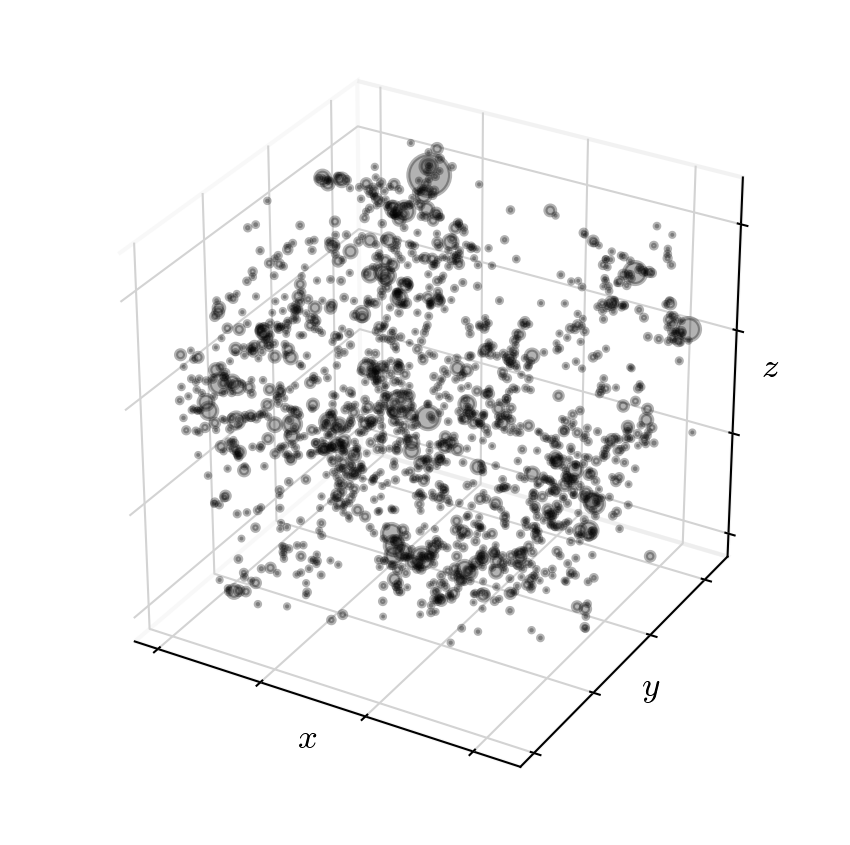

In [5]:
fig, ax = plt.subplots(1, subplot_kw={'projection': '3d'})
ax.set_xlabel(r"$x$", labelpad=-15)
ax.set_ylabel(r"$y$", labelpad=-15)
ax.set_zlabel(r"$z$", labelpad=-15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# fig.suptitle("%d haloes at snapshot %d" % (len(haloes), snap))

ax.scatter(
    *haloes['CenterComoving'].T,
    s=100*(haloes['M200Crit'] / haloes['M200Crit'].max()),
    c='k',
    alpha=0.3,
)

In [7]:
def nearest_neighbour(halo, f=1.0, N=0):
    """N-th neighbour more massive then f*M (M of halo h).
    
    .. todo::

        Error handling for small numbers of haloes

    """

    _haloes = haloes[
        (haloes["HaloId"] != halo["HaloId"])
        & (haloes["M200Crit"] >= f * halo["M200Crit"])
    ]

    if len(_haloes) < 1:
        d = np.nan

    else:
        d = (
            np.sort(
                np.sqrt(
                    np.sum(
                        np.power(
                            halo["CenterComoving"]
                            - _haloes["CenterComoving"],
                            2.0,
                        ),
                        axis=1,
                    )
                )
            )[N]
            / halo["R200CritComoving"]
        )

    return d

In [7]:
#TODO

def spherical_overdensity(halo, r=5):
    """(Over)density within radius ``r`` of halo center.
    """
    return 0.0

def shell_overdensity(halo, r_min=1, r=5):
    """(Over)density within shell between ``r_min`` and ``r``.
    """
    return 0.0

def experienced_potential(halo):
    """Experienced gravity for a halo.
    """
    c = halo['NFW_c']
    r_s = nfw.r_s(c)
    delta_c = nfw.delta_c(c)

    rs = np.linspace(-2.0, 0.0, 100)
    phi = [phi(r) for r in rs]

    phi_star = phi + 4*np.pi*G*delta_c * cosmology.rho_crit(halo['snap']) * \
        np.div((r_s * r_s * r_s), rs) * np.log(1.0 + rs / r_s)

    return np.mean(phi_star)

In [8]:
dnf = np.log10([nearest_neighbour(halo) for halo in tqdm(haloes)])

100%|██████████| 1577/1577 [00:00<00:00, 2757.80it/s]


In [14]:
def plot3d(xs, ys, zs, ss, cs):
    ix = ~np.isnan(cs)
    xs, ys, zs, ss, cs = xs[ix], ys[ix], zs[ix], ss[ix], cs[ix]

    scalarMap = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs)),
        cmap=plt.get_cmap('viridis')
    )
    scalarMap.set_array(cs)
    fig, ax = plt.subplots(1, figsize=[4, 3.6], subplot_kw={'projection': '3d'})
    ax.set_xlabel(r"$x$", labelpad=-15)
    ax.set_ylabel(r"$y$", labelpad=-15)
    ax.set_zlabel(r"$z$", labelpad=-15)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    fig.colorbar(scalarMap).ax.set_ylabel(r"$\log_{10}(D_{N,f})$", rotation=270, labelpad=10)
    ax.scatter(xs, ys, zs, s=30*(ss / np.max(ss)), c=scalarMap.to_rgba(cs))
    fig.tight_layout()
    
    return fig, ax

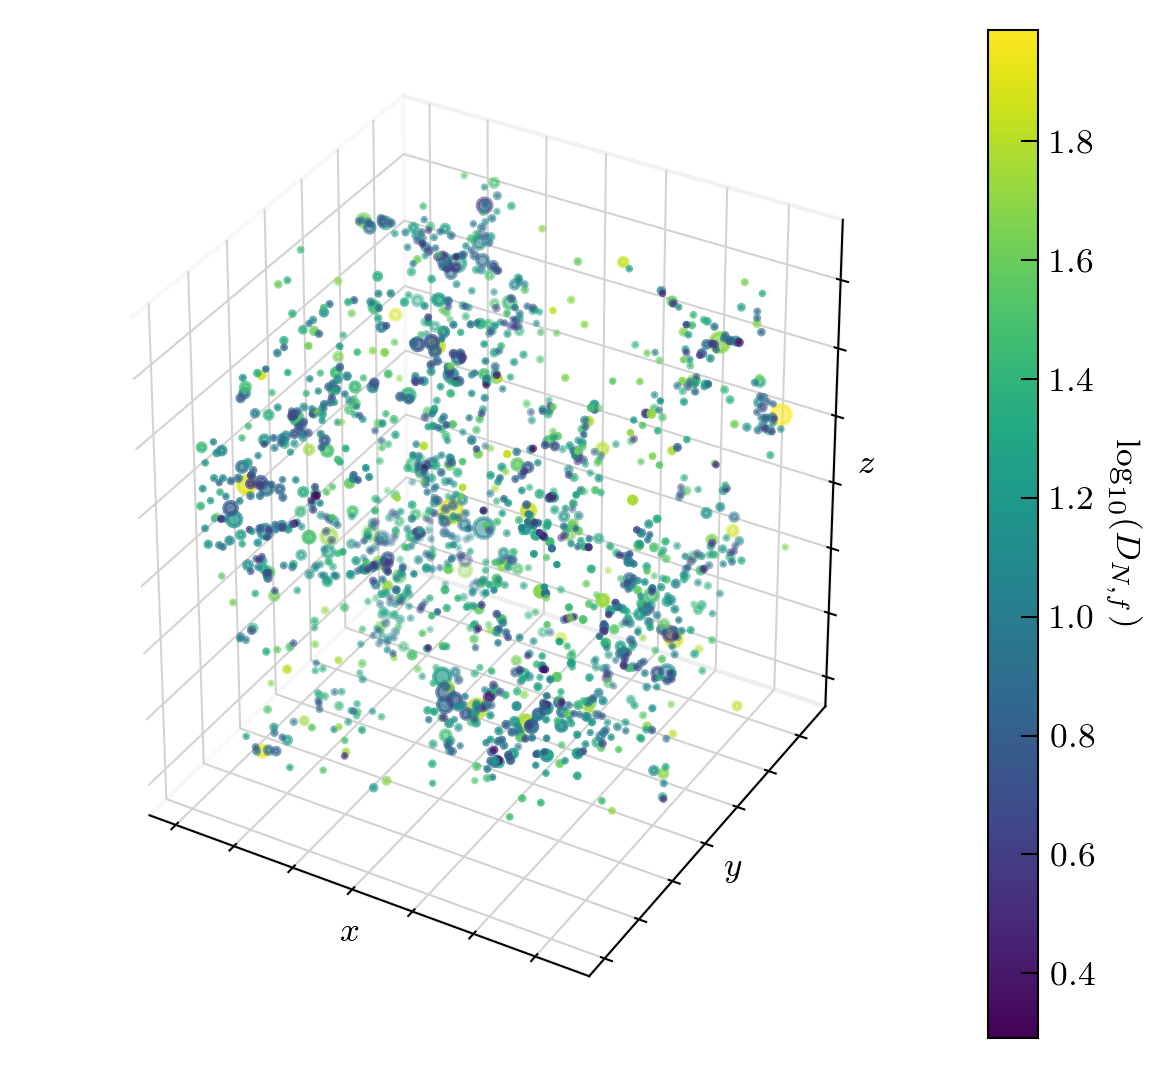

In [15]:
fig, ax = plot3d(
    *haloes['CenterComoving'].T,
    ss=haloes['M200Crit'],
    cs=dnf,
)

# fig.savefig("./plots/3d.pdf")

In [11]:
d = pd.DataFrame({
    'm': np.log10(1e10*haloes['M200Crit']),
    'd': dnf,
})
d['m_bin'] = pd.cut(
    d['m'],
    np.linspace(
        d['m'].min(),
        d['m'].max(), nbins + 1
    ),
    retbins=False,
    labels=np.arange(1, nbins+1)
)

dnf_quantiles = d.groupby('m_bin').quantile([.25, .75])['d']
dnf_quantiles

m_bin      
1      0.25    0.885478
       0.75    1.354635
2      0.25    0.863982
       0.75    1.325207
3      0.25    0.850583
       0.75    1.313647
4      0.25    0.871452
       0.75    1.384126
5      0.25    0.920641
       0.75    1.377212
6      0.25    0.838243
       0.75    1.331171
7      0.25    1.099347
       0.75    1.475010
8      0.25    1.046012
       0.75    1.412559
9      0.25    1.054402
       0.75    1.594576
10     0.25    0.918356
       0.75    1.502485
11     0.25    0.982529
       0.75    1.595104
12     0.25    0.799811
       0.75    1.538707
13     0.25    1.040614
       0.75    1.642196
14     0.25    1.226181
       0.75    1.872160
15     0.25    1.741511
       0.75    1.891834
16     0.25    1.069210
       0.75    1.069210
17     0.25    1.861859
       0.75    1.861859
18     0.25         NaN
       0.75         NaN
19     0.25         NaN
       0.75         NaN
20     0.25         NaN
       0.75         NaN
Name: d, dtype: float64

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


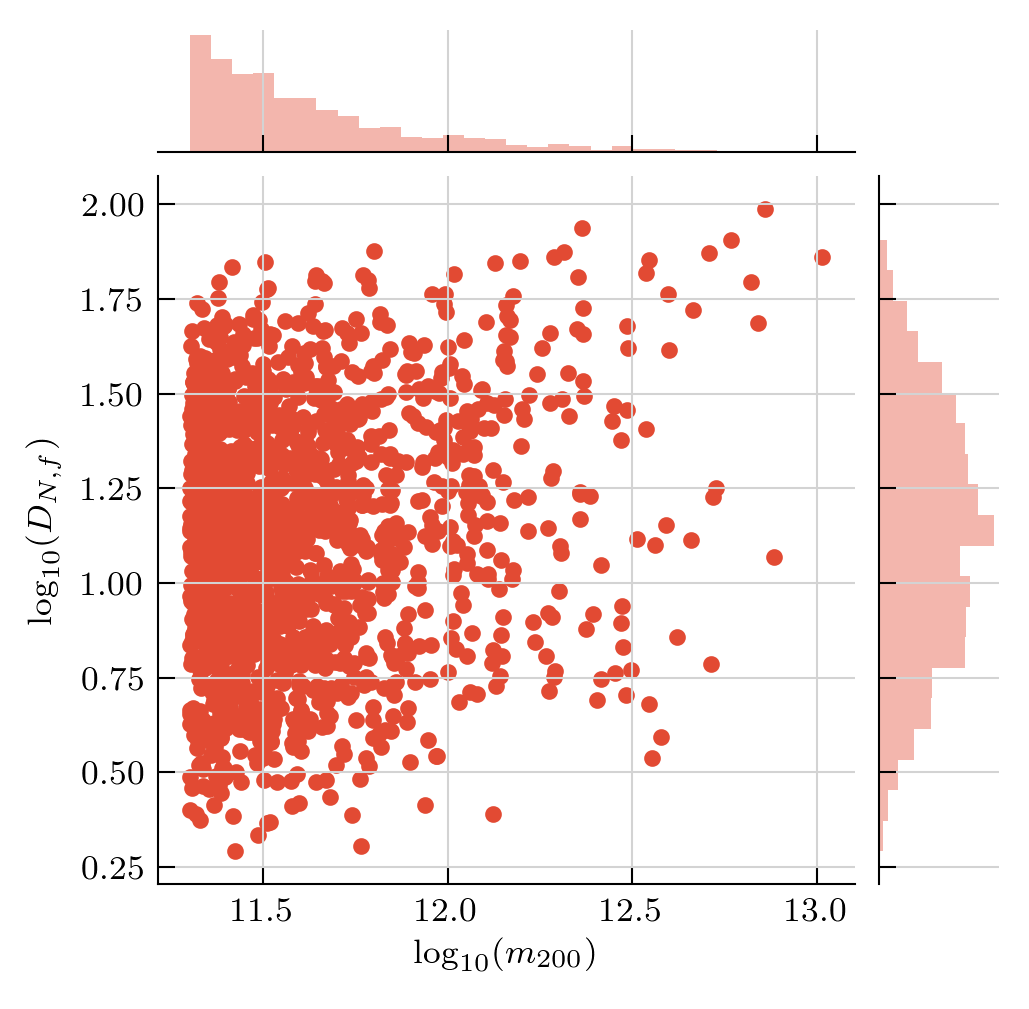

In [12]:
p = sns.jointplot(
    x="m", y="d",
    data=d,
    marker='.',
    stat_func=None,
    size=3.4,
)

p.set_axis_labels(r"$\log_{10}(m_{200})$", r"$\log_{10}(D_{N,f})$")
# p.savefig("./plots/dnf_all.pdf")

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


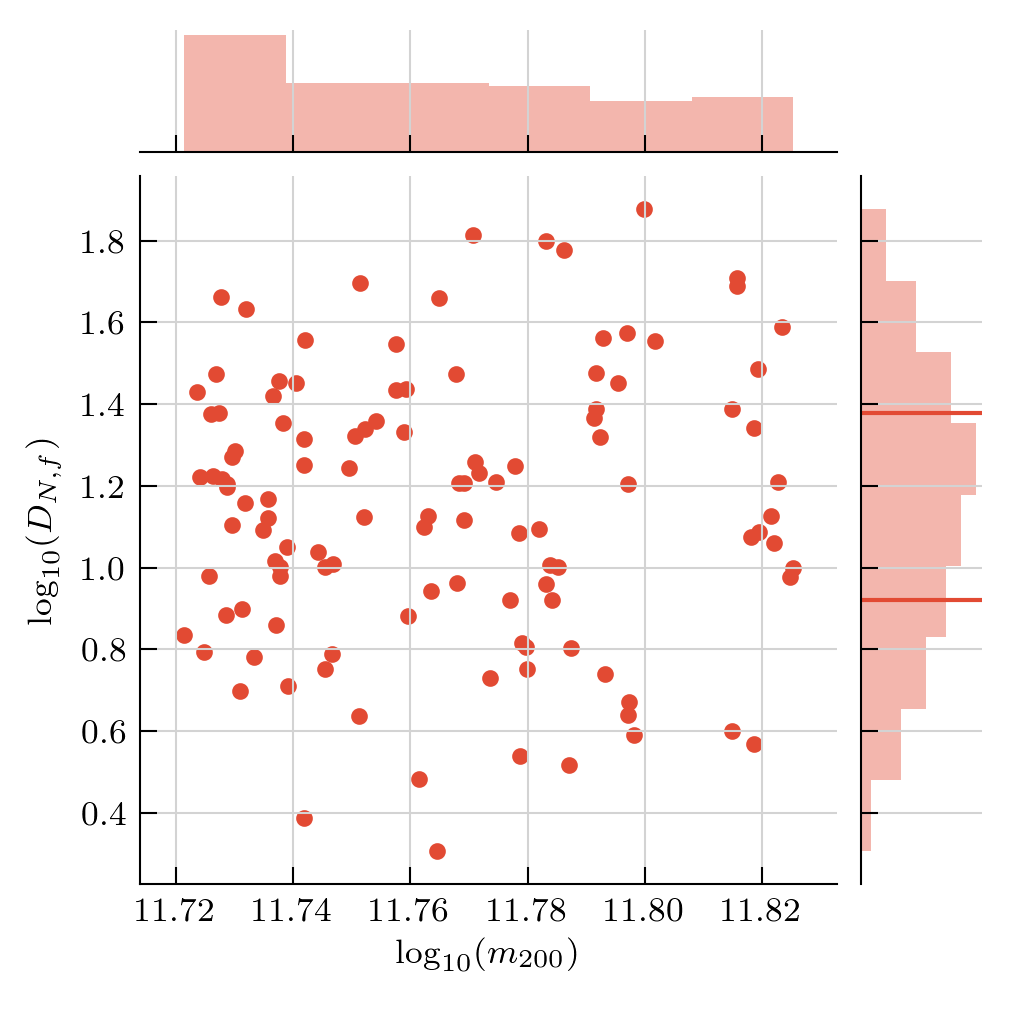

In [13]:
p = sns.jointplot(
    x="m", y="d",
    data=d[d['m_bin'] == bin],
    marker='.',
    stat_func=None,
    size=3.4,
)

# p.fig.suptitle(
#     "%d haloes in bin %d at snapshot %d, N=1, f=1.0"
#     % (len(d[d['m_bin'] == bin]), bin, snap))

plt.axhline(dnf_quantiles.loc[bin].iloc[0])
plt.axhline(dnf_quantiles.loc[bin].iloc[1])

p.set_axis_labels(r"$\log_{10}(m_{200})$", r"$\log_{10}(D_{N,f})$")

# p.savefig("./plots/dnf_bin.pdf")